In [15]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4.5)

from util import util
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_cmapss_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1])

data_by_src = util.partition_by_field(data, field='src')
dt = data_by_src['train_FD004']

trs_ratio = 0.03 # Supervised experiments / all experiments
tru_ratio = 0.6 # Unsupervised experiments / remaining experiments
trs, tmp = util.split_datasets_by_field(dt, field='machine', fraction=trs_ratio, seed=42)
tru, ts = util.split_datasets_by_field(tmp, field='machine', fraction=tru_ratio, seed=42)

trs_mcn, tru_mcn, ts_mcn = trs['machine'].unique(), tru['machine'].unique(), ts['machine'].unique()

sscaler, nscaler = StandardScaler(), MinMaxScaler()
trs_s, tru_s, ts_s = trs.copy(), tru.copy(), ts.copy()
trs_s[dt_in] = sscaler.fit_transform(trs[dt_in])
tru_s[dt_in], ts_s[dt_in] = sscaler.transform(tru[dt_in]), sscaler.transform(ts[dt_in])
trs_s[['rul']] = nscaler.fit_transform(trs[['rul']])
tru_s[['rul']], ts_s[['rul']] = nscaler.transform(tru[['rul']]), nscaler.transform(ts[['rul']])

maxrul = nscaler.data_max_[0]

tru_s2 = util.rul_cutoff_and_removal(tru_s, cutoff_min=20, cutoff_max=60, seed=42)
tr_s2 = pd.concat((trs_s, tru_s2))

stop = 1400
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Knowledge Injection in RUL

Let's see the last approach in action

## Domain Knowledge as Constraints

**Our soft constraint is in the form:**

$$\begin{align}
& f(x_i; \theta) - f(x_j; \theta) \simeq j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

From which we can derive the penalizer:

$$
\lambda \sum_{\substack{i, j = 1..m \\ c_i = c_j}} \left(f(x_i; \theta) - f(x_j; \theta) - (j-i)\right)^2
$$

* For sake of simplicity, we are using the same $\lambda$ for all pairs
* ...Meaning the same standard deviation using a Normal semantic

**There's large number of constraints, but many are redundant**

## Our Regularizer

**For example, we can focus on subsequent pairs**

$$
L(\hat{y}) + \lambda \sum_{\substack{i \prec j \\ c_i = c_j}} \left(f(x_i; \theta) - f(x_j; \theta) - (j-i)\right)^2
$$

* Where $i \prec j$ iff $j$ is the next sample for after $i$ for a given machine 
* This approach requires a linear (rather than quadratic) number of constraints

**This method can work with mini-batches**

* In this case, $\prec$ will refer to contiguous samples _in the same batch_
* ...And of course for the same component

**We will now see how to implement this approach**

## Generating Batches from the Same Machine

**Our regularizer requires to have _sorted_ samples _from the same machine_**

The easiest way to ensure we have enough is using a custom `DataGenerator`


```python
class SMBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, in_cols, batch_size, seed=42): ...
    def __len__(self): ...
    def __getitem__(self, index): ...
    def on_epoch_end(self): ...
    def __build_batches(self): ...
```

* `__len__` is called to know how many batches are left
* `__getitem__` should return one batch
* `on_epoch_end` should take care (e.g.) of shuffling

## Generating Batches from the Same Machine

**The `__init__` method takes care of the initial setup**

```python
def __init__(self, data, in_cols, batch_size, seed=42):
    super(SMBatchGenerator).__init__()
    self.data = data
    self.in_cols = in_cols
    self.dpm = split_by_field(data, 'machine')
    self.rng = np.random.default_rng(seed)
    self.batch_size = batch_size
    # Build the first sequence of batches
    self.__build_batches()
```

* We store some fields
* We split the data by machine
* We build a dedicated RNG
* ...And finally we call the custom-made `__build_batches` method

## Generating Batches from the Same Machine

**The `__build_batches` method prepares the batches for one full epoch**

```python
def __build_batches(self):
    self.batches, self.machines = [], []
    mcns = list(self.dpm.keys()) 
    self.rng.shuffle(mcns) # sort the machines at random
    for mcn in mcns: # Loop over all machines
        index = self.dpm[mcn].index # sample indexes for this machine
        ...
        self.rng.shuffle(idx) # shuffle sample indexes for this machine
        bt = idx.reshape(-1, self.batch_size) # split into batches
        bt = np.sort(bt, axis=1) # sort every batch individually
        self.batches.append(bt) # store the batch
        self.machines.append(np.repeat([mcn], len(bt))) # add machine information
    self.batches = np.vstack(self.batches) # concatenate
    self.machines = np.hstack(self.machines)
```

## Generating Batches from the Same Machine

**We rebuild batches after each epoch**

```python
def on_epoch_end(self):
    self.__build_batches()
```

**Most of the remaining work is done in the `__getiitem__` method:**

```python
def __getitem__(self, index):
    idx = self.batches[index]
    x = self.data[self.in_cols].loc[idx].values
    y = self.data['rul'].loc[idx].values
    flags = (y != -1)
    info = np.vstack((y, flags, idx)).T
    return x, info
```

* The RUL value is -1 for the unsupervised data: we flag the meaningful RULs
* ...We pack indexes, RUL values, and flags into a single `info` tensor

## Custom Training Step

**We then enforce the constraints by means of a _custom training step_**

```python
class CstRULRegressor(keras.Model):
    def __init__(self, rul_pred, alpha, beta, maxrul): ...
        
    def train_step(self, data): ...
        
    def call(self, data): return self.rul_pred(data)

    ...
```

* We use a custom `keras.Model` subclass
* ...And accept an externally built RUL prediction model (`rul_pred`)
* The custom training step is implemented in `train_step`
* The `call` method relies on the external model for RUL prediction

## Custom Training Step

**In the `__init__` function:**

```python
def __init__(self, rul_pred, alpha, beta, maxrul):
    super(CstRULRegressor, self).__init__(input_shape, hidden)
    # Store the base RUL prediction model
    self.rul_pred = rul_pred
    # Weights
    self.alpha = alpha
    self.beta = beta
    self.maxrul = maxrul
    ...
```

* `beta` is the regularizer weight, `alpha` is a weight for the loss function itself
* We also store the maximum RUL

## Custom Training Step

**In the custom training step:**

```python
def train_step(self, data):
    x, info = data
    y_true, flags, idx = info[:, 0:1], info[:, 1:2], info[:, 2:3]
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True) # predictions
        mse = tf.math.reduce_mean(flags * tf.math.square(y_pred-y_true)) # MSE loss
        delta_pred = y_pred[1:] - y_pred[:-1] # pred. difference
        delta_rul = -(idx[1:] - idx[:-1]) /self.maxrul # index difference
        deltadiff = delta_pred - delta_rul # difference of differences
        cst = k.mean(k.square(deltadiff)) # regualization term
        loss = self.alpha * mse + self.beta * cst # loss
    ...
```

* We unpack the `info` tensor
* Inside a `GradientTape`, we construct our regularized loss

## Custom Training Step

**In the custom training step:**

```python
def train_step(self, data):
    ...
    tr_vars = self.trainable_variables
    grads = tape.gradient(loss, tr_vars) # gradient computation
    
    self.optimizer.apply_gradients(zip(grads, tr_vars)) # weight update
    
    ...
```

* We then apply the (Stochastic) Gradient Descent step
* Then we update and retun the loss trackers

## Training the Lagrangian Approach

**We can now test our approach**

In [22]:
nn_aux = util.build_nn_model(input_shape=(len(dt_in),), output_shape=(1,), hidden=[32, 32])
nn2 = util.CstRULRegressor(rul_pred=nn_aux, alpha=1, beta=3, maxrul=maxrul)
batch_gen = util.CstBatchGenerator(tr_s2, dt_in, batch_size=32)
history = util.train_nn_model(nn2, X=batch_gen, y=None, loss=None, validation_split=0., epochs=25, verbose=1)

Epoch 1/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0072 - loss: 0.0250 - mse: 0.0034
Epoch 2/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0021 - loss: 0.0088 - mse: 0.0026
Epoch 3/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0019 - loss: 0.0086 - mse: 0.0028
Epoch 4/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0019 - loss: 0.0078 - mse: 0.0020
Epoch 5/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - cst: 0.0019 - loss: 0.0083 - mse: 0.0025
Epoch 6/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0019 - loss: 0.0073 - mse: 0.0017
Epoch 7/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - cst: 0.0019 - loss: 0.0078 - mse: 0.0022
Epoch 8/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0019 - loss: 0.0079 - mse: 0.0022
Epoch 9/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0018 - loss: 0.0079 - mse: 0.0024
Epoch 10/25
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - cst: 0.0019 - loss: 0.0079 - mse: 0.0023
Epoch 11/25
1071/1071 ━━━━━━━

## Training the Lagrangian Approach

**...And we can check the training curve**

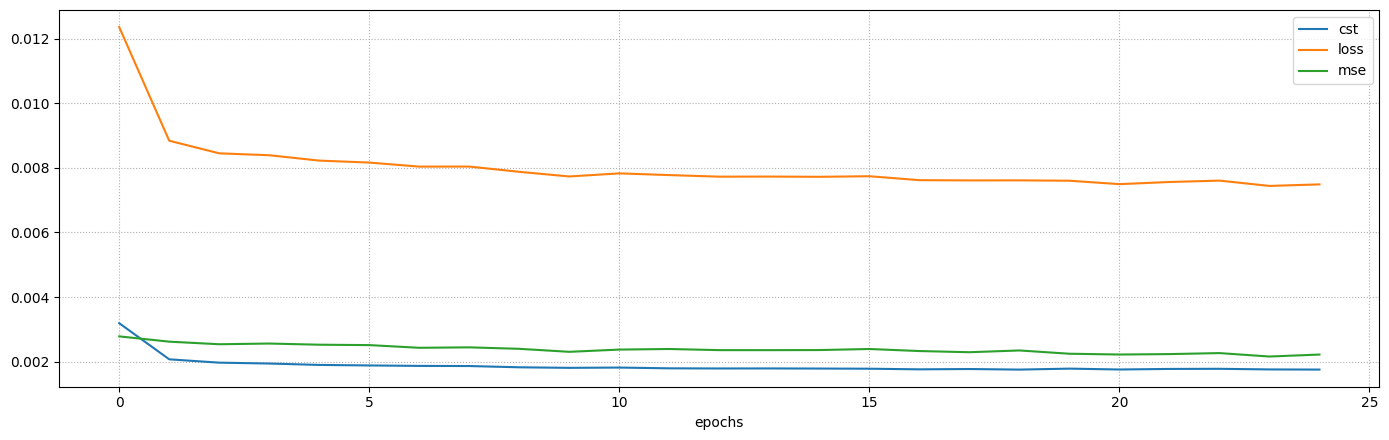

Final loss: 0.0075 (training)


In [23]:
util.plot_training_history(history, figsize=figsize)

## Inspecting the Predictions

**Let's have a look at the predictions on the _test_ data**

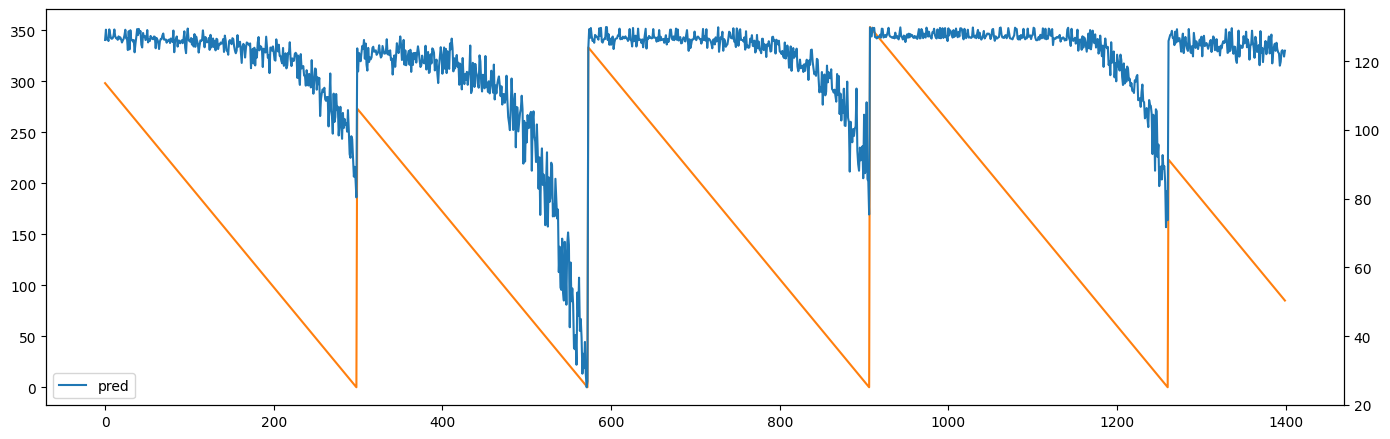

In [24]:
ts_pred2 = nn2.predict(ts_s[dt_in], verbose=0).ravel() * maxrul
util.plot_rul(ts_pred2[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* The signal is _much more stable_
* The scale is still off, but we can fix that with a well chosen threshold

## Threshold Optimization and Cost Evaluation

**We can now optimize the threshold optimization (on the supervised data)**

Optimal threshold for the training set: 91.31


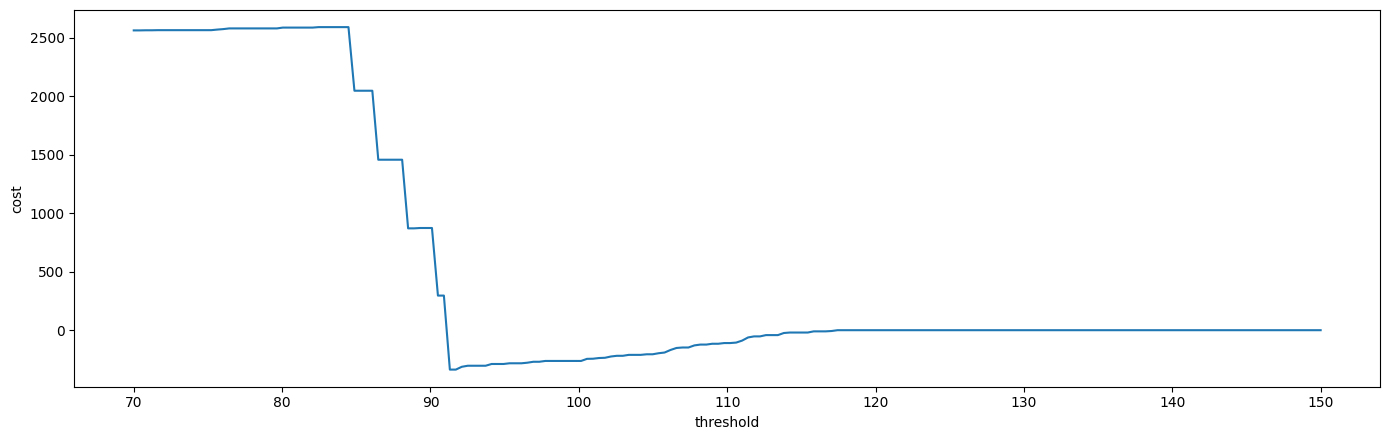

In [25]:
trs_pred2 = nn2.predict(trs_s[dt_in], verbose=0).ravel() * maxrul
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range2 = np.linspace(70, 150, 200)
trs_thr2 = util.optimize_threshold(trs_s['machine'].values, trs_pred2, th_range2, cmodel, plot=True, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr2:.2f}')

## Threshold Optimization and Cost Evaluation

**Finally, we can evaluate the SBR approach in terms of cost**

In [26]:
tru_pred2 = nn2.predict(tru_s[dt_in], verbose=0).ravel() * maxrul
trs_c2, trs_f2, trs_sl2 = cmodel.cost(trs_s['machine'].values, trs_pred2, trs_thr2, return_margin=True)
tru_c2, tru_f2, tru_sl2 = cmodel.cost(tru_s['machine'].values, tru_pred2, trs_thr2, return_margin=True)
ts_c2, ts_f2, ts_sl2 = cmodel.cost(ts['machine'].values, ts_pred2, trs_thr2, return_margin=True)
print(f'Cost: {trs_c2/len(trs_mcn):.2f} (supervised), {tru_c2/len(tru_mcn):.2f} (unsupervised), {ts_c2/len(ts_mcn):.2f} (test)')

Cost: -48.14 (supervised), -77.90 (unsupervised), -70.34 (test)


In [27]:
print(f'Avg. fails: {trs_f2/len(trs_mcn):.2f} (supervised), {tru_f2/len(tru_mcn):.2f} (unsupervised), {ts_f2/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl2/len(trs_mcn):.2f} (supervised), {tru_sl2/len(tru_mcn):.2f} (unsupervised), {ts_sl2/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.04 (unsupervised), 0.04 (test)
Avg. slack: 20.43 (supervised), 20.14 (unsupervised), 19.85 (test)


* The number of fails has decreased very significantly
* The slack is still contained

**And we did this with _just a handful_ of run-to-failure experiments**